In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm
import warnings

## Poject: <a style="color:purple;">**Analysis of the US Economy**</a> - part 3

#### Author: @**engine**, Date: February 2025

### Abstract:
**!!!** TODO ........... TODO ........... TODO ........... TODO ........... TODO ........... TODO ........... TODO ........... TODO ........... <b>!!!</b>

### 1. **Introduction**

This study is a continuation of the previous two. The latter predicted the likelihood of a recession and indicated why one might not be declared. From here we ask ourselves the next logical question: can we measure the resilience of the US economy? And how? And also, how does US debt fit into all these processes of economic sustainability?

On the site **[Sustainable Economic Indicators](https://www.sustainable-environment.org.uk/Indicators/Economy.php)** we read:<br>
**Total GDP** and **GDP per capita** are good indicators of the relative strengths of the worlds nations.
Other indicators may include:

 - Investment in public, business and private assets (headline);
 - Social investment;
 - Rate of inflation;
 - Government borrowing and debt;
 - Competitiveness/productivity;
 - Trade/exports/imports.

However, it is increasingly being recognised these traditional economic indicators alone do not provide an adequate measure of an economy’s sustainability. To improve upon these indicators, we need to know how resource efficient our economy is, both in terms of the natural resources that it consumes (and wastes) and its utilisation of labour capital. Some indicators that have been proposed by the Government in this respect include:

 - Waste production, and energy and water consumption;
 - Transport indicators;
 - Education and employment;
 - Consumer expenditure;
 - Environmental management and reporting. [1]

This study **<a style="color:purple;">cannot cover all aspects of the sustainability of an economy</a>**, from internal social contradictions... to the state of the environment (ecology). But we **can safely use the most important indicators, which we can put into numbers** and then with **AI models**:

- **GROSS DOMESTIC PRODUCT** (**<a style="color:purple;">GDP</a>**) => Competitiveness/productivity;
- **Real GDP per capita** (A939RX0Q048SBEA) => Competitiveness/productivity;
- **Total Public Debt as Percent of GDP** (GFDEGDQ188S) => Competitiveness/productivity;<br>

- **Consumer Price Index** (CPI) => Consumer expenditure;
- **Industrial Production Index** (INDPRO) => Competitiveness/productivity;
- **S&P 500 Index** (SP500) => Investment in public, business and private assets;
- **Total Nonfarm Payroll** (PAYEMS) => Competitiveness/productivity (jobs);
- **Unemployment** (UNRATE) => Education and employment;
- **Federal Funds Effective Rate** (FEDFUNDS) => Rate of inflation;
- **Federal Debt: Total Public Debt** (GFDEBTN) => Government borrowing and debt;
- **Personal Saving Rate** (PSAVERT) => Social investment;
- **Trade Balance: Goods and Services, Balance of Payments Basis** (BOPGSTB) => Trade/exports/imports;
- Personal consumption expenditures: **Energy goods and services** (DNRGRC1M027SBEA) => Waste production, and energy and water consumption.

For some of the data we will be able to easily interpolate back in time. Some of the data that we can include are not freely available, and others are either abandoned for collection back in time, or are being collected recently. **Back in time**, in the general case, we get a practical limit from **January 1966**, and for the moment we only have a limited amount of this data, which is published quarter by quarter. And with a great delay.

### 2. **Collection of economic indicators**

#### 2.1 GROSS DOMESTIC PRODUCT (GDP)

From this site **[FEDERAL RESERVE BANK of ST. LOUIS](https://fred.stlouisfed.org/series/GDP)** we only download information for the period of our study: **<a style="color:purple;">Gross Domestic Product (GDP)</a>**. [001] Units: **Billions of Dollars**, Seasonally Adjusted. Frequency: Quarterly.

In [5]:
gdp = pd.read_csv('data/GDP.csv') # Read the CSV file.
gdp.columns = ["date", "gdp"]
gdp['gdp'] = gdp['gdp'] * 1_000_000_000 # Convert to dollars.

Data for the period under study are given by **quartals**, not by months. To obtain all the requested data from **01.1962** to **the end of the study period**, we use a **linear approximation**.

In [7]:
gdp['date'] = pd.to_datetime(gdp['date'])
gdp_approx = gdp.copy()

# Create a new DataFrame with all dates from 1966-01-01 to end of period.
all_dates = pd.date_range(start='1966-01-01', end='2024-09-01', freq='MS')
gdp_all_dates = pd.DataFrame({'date': all_dates})

# Merge the two DataFrames and interpolate.
gdp_approx = pd.merge(gdp_all_dates, gdp, on='date', how='left')

# Linear interpolation.
gdp_approx['gdp'] = gdp_approx['gdp'].interpolate(method='linear')

# Remove the 'year' and 'month' columns.
if 'year' in gdp_approx.columns:
    gdp_approx = gdp_approx.drop(columns=['year'])
if 'month' in gdp_approx.columns:
    gdp_approx = gdp_approx.drop(columns=['month'])
gdp_approx

,date,gdp
0,1966-01-01,7.957340e+11
1,1966-02-01,7.988163e+11
2,1966-03-01,8.018987e+11
3,1966-04-01,8.049810e+11
4,1966-05-01,8.098667e+11
...,...,...
700,2024-05-01,2.912778e+13
701,2024-06-01,2.923885e+13
702,2024-07-01,2.934992e+13
703,2024-08-01,2.934992e+13


#### 2.2 CONSUMER PRICE INDEX (CPI)

From this site **[FEDERAL RESERVE BANK of ST. LOUIS](https://fred.stlouisfed.org/series/CPIAUCSL)** we only download information for the period of our study: **<a style="color:purple;">Consumer Price Index (CPI)</a>** for All Urban Consumers, All Items in U.S. City Average (CPIAUCSL). [xx] Units: **Index**, Seasonally Adjusted. Frequency: Monthly.

In [9]:
cpi = pd.read_csv('data/CPIAUCSL.csv') # Read the CSV file.
cpi.columns = ["date", "cpi"]
cpi

,date,cpi
0,1966-01-01,31.880
1,1966-02-01,32.080
2,1966-03-01,32.180
3,1966-04-01,32.280
4,1966-05-01,32.350
...,...,...
700,2024-05-01,313.225
701,2024-06-01,313.049
702,2024-07-01,313.534
703,2024-08-01,314.121


#### 2.3 Industrial Production Index (INDPRO)

From this site **[FEDERAL RESERVE BANK of ST. LOUIS](https://fred.stlouisfed.org/series/INDPRO)** we download information for the period of our study: **<a style="color:purple;">Industrial Production Index (INDPRO)</a>** [xx], Seasonally Adjusted. Frequency: Monthly.

In [11]:
indpro = pd.read_csv('data/INDPRO.csv') # Read the CSV file
indpro.columns = ["date", "indpro"]
indpro

,date,indpro
0,1966-01-01,33.1709
1,1966-02-01,33.3859
2,1966-03-01,33.8429
3,1966-04-01,33.8967
4,1966-05-01,34.2192
...,...,...
700,2024-05-01,103.0711
701,2024-06-01,103.2258
702,2024-07-01,102.5863
703,2024-08-01,102.9329


#### 2.4 S&P 500 Index (SP500)

From this site **[Stooq](https://stooq.com/q/d/?s=%5Espx&c=0&d1=19620101&d2=20241001&i=m)** we download information for the period of our study: **<a style="color:purple;">S&P 500 Index (SP500)</a>** [xx], Frequency: Monthly. This is the only publicly available data for the S&P 500 Index, which contains information all the way back to 1962!

In [13]:
sp = pd.read_csv('data/SP500.csv') # Read the CSV file
# Keep only the required columns.
keep_col = ['Date', 'Close']
sp500 = sp[keep_col]
del sp
# Renaming columns.
sp500.columns = ['date', 'sp500']
sp500

,date,sp500
0,1966-01-31,92.88
1,1966-02-28,91.22
2,1966-03-31,89.23
3,1966-04-30,91.06
4,1966-05-31,86.13
...,...,...
700,2024-05-31,5277.51
701,2024-06-30,5460.48
702,2024-07-31,5522.30
703,2024-08-31,5648.40


#### 2.5 Total Nonfarm Payroll (PAYEMS)

From this site **[FEDERAL RESERVE BANK of ST. LOUIS](https://fred.stlouisfed.org/series/PAYEMS)** we download information for the period of our study: **<a style="color:purple;">Total Nonfarm Payroll (PAYEMS)</a>** [xx], Units: **Thousands of Persons**, Seasonally Adjusted. Frequency: Monthly.

In [15]:
payems = pd.read_csv('data/PAYEMS.csv') # Read the CSV file
payems.columns = ["date", "payems"]
payems

,date,payems
0,1966-01-01,62529
1,1966-02-01,62796
2,1966-03-01,63192
3,1966-04-01,63437
4,1966-05-01,63712
...,...,...
700,2024-05-01,158430
701,2024-06-01,158548
702,2024-07-01,158692
703,2024-08-01,158851


#### 2.6 UNEMPLOYMENT (UNRATE)

From this site **[FEDERAL RESERVE BANK of ST. LOUIS](https://fred.stlouisfed.org/series/UNRATE)** we only download information for the period of our study: **<a style="color:purple;">Monthly Unemployment Rate (UNRATE)</a>**. [xx] Units: **Percent**</a>, Seasonally Adjusted. Frequency: Monthly. 

In [17]:
unemployment = pd.read_csv('data/UNRATE.csv')
unemployment.columns = ["date", "unemployment"]
unemployment["unemployment"] = unemployment["unemployment"] / 100 # To get in percentages.
unemployment

,date,unemployment
0,1966-01-01,0.040
1,1966-02-01,0.038
2,1966-03-01,0.038
3,1966-04-01,0.038
4,1966-05-01,0.039
...,...,...
700,2024-05-01,0.040
701,2024-06-01,0.041
702,2024-07-01,0.043
703,2024-08-01,0.042


#### 2.7  Federal Funds Effective Rate (FEDFUNDS)

From this site **[Federal Reserve Bank of St. Louis](https://fred.stlouisfed.org/series/FEDFUNDS)** we only download information for the period of our study: **<a style="color:purple;">Federal Funds Effective Rate (FEDFUNDS)</a>**, Units: **Percent**. Frequency: Monthly [xx]

In [19]:
fedfunds = pd.read_csv('data/FEDFUNDS.csv')
fedfunds.columns = ["date", "fedfunds"]
fedfunds["fedfunds"] = fedfunds["fedfunds"] / 100 # To get in percentages.
fedfunds

,date,fedfunds
0,1966-01-01,0.0442
1,1966-02-01,0.0460
2,1966-03-01,0.0466
3,1966-04-01,0.0467
4,1966-05-01,0.0490
...,...,...
700,2024-05-01,0.0533
701,2024-06-01,0.0533
702,2024-07-01,0.0533
703,2024-08-01,0.0533


#### 2.8 Total Public Debt (GFDEBTN)

From this site **[Federal Reserve Bank of St. Louis](https://fred.stlouisfed.org/series/GFDEBTN)** we only download information for the period of our study: **<a style="color:purple;">Federal Debt: Total Public Debt (GFDEBTN)</a>**, Units: **Millions of Dollars**, Not Seasonally Adjusted. Frequency: Quarterly [xx]

In [21]:
debt = pd.read_csv('data/GFDEBTN.csv') # Loading data.
debt.columns = ["date", "debt"]
debt['debt'] = debt['debt'] * 1_000_000 # Convert to dollars.

# Преобразуване на колоната 'date' в datetime
debt['date'] = pd.to_datetime(debt['date'])

# Създаване на нов DataFrame с всички дати от 1966-01-01 до края на периода.
all_dates = pd.date_range(start='1966-01-01', end='2024-09-01', freq='MS')
debt_all_dates = pd.DataFrame({'date': all_dates})

# Сливане на двата DataFrame и интерполация.
debt_approx = pd.merge(debt_all_dates, debt, on='date', how='left')

# Линейна интерполация.
debt_approx['debt'] = debt_approx['debt'].interpolate(method='linear')

# Премахване на колоните 'year' и 'month', ако съществуват
if 'year' in debt_approx.columns:
    debt_approx = debt_approx.drop(columns=['year'])
if 'month' in debt_approx.columns:
    debt_approx = debt_approx.drop(columns=['month'])
    
debt_approx # __________________________ not ready yet! ____________________ not ready yet! _______ => 2024-04 <= !!! __________ !!!

,date,debt
0,1966-01-01,3.209990e+11
1,1966-02-01,3.193650e+11
2,1966-03-01,3.177310e+11
3,1966-04-01,3.160970e+11
4,1966-05-01,3.189807e+11
...,...,...
700,2024-05-01,3.483163e+13
701,2024-06-01,3.483163e+13
702,2024-07-01,3.483163e+13
703,2024-08-01,3.483163e+13


#### 2.9   Personal Saving Rate (PSAVERT)

From this site **[Federal Reserve Bank of St. Louis](https://fred.stlouisfed.org/graph/?g=580A)** we only download information for the period of our study: **<a style="color:purple;">Personal Saving Rate (PSAVERT)</a>**, Units: **Percent**, Seasonally Adjusted. Frequency: Monthly [xx]<br> 
Personal saving is equal to personal income less personal outlays and personal taxes; it may generally be viewed as the portion of personal income that is used either to provide funds to capital markets or to invest in real assets such as residences.

In [23]:
pasavert = pd.read_csv('data/PSAVERT.csv') # Loading data.
pasavert.columns = ["date", "pasavert"]
pasavert["pasavert"] = pasavert["pasavert"] / 100 # To get in percentages.
pasavert

,date,pasavert
0,1966-01-01,0.112
1,1966-02-01,0.110
2,1966-03-01,0.107
3,1966-04-01,0.103
4,1966-05-01,0.112
...,...,...
700,2024-05-01,0.052
701,2024-06-01,0.052
702,2024-07-01,0.049
703,2024-08-01,0.048


#### 2.10 Real gross domestic product per capita (A939RX0Q048SBEA)

From this site **[FEDERAL RESERVE BANK of ST. LOUIS](https://fred.stlouisfed.org/series/A939RX0Q048SBEA)** we only download information for the period of our study: **<a style="color:purple;">Real gross domestic product per capita (A939RX0Q048SBEA)</a>**. [xx] Units: **Dollars**, Seasonally Adjusted. Frequency: Quarterly.

In [25]:
gdp_pca = pd.read_csv('data/A939RX0Q048SBEA.csv') # Read the CSV file.
gdp_pca.columns = ["date", "gdp_pca"]

Data for the period under study are given by **quartals**, not by months. To obtain all the requested data from **01.1966** to **the end of the study period**, we use a **linear approximation**.

In [27]:
gdp_pca['date'] = pd.to_datetime(gdp_pca['date'])
gdp_pca_approx = gdp_pca.copy()

# Create a new DataFrame with all dates from 1966-01-01 to end of period
all_dates = pd.date_range(start='1966-01-01', end='2024-09-01', freq='MS')
gdp_pca_all_dates = pd.DataFrame({'date': all_dates})

# Merge с правилния DataFrame (gdp_pca вместо gdp)
gdp_pca_approx = pd.merge(gdp_pca_all_dates, gdp_pca, on='date', how='left')

# Linear interpolation
gdp_pca_approx['gdp_pca'] = gdp_pca_approx['gdp_pca'].interpolate(method='linear')

# Remove the 'year' and 'month' columns if they exist
if 'year' in gdp_pca_approx.columns:
    gdp_pca_approx = gdp_pca_approx.drop(columns=['year'])
if 'month' in gdp_pca_approx.columns:
    gdp_pca_approx = gdp_pca_approx.drop(columns=['month'])

gdp_pca_approx

,date,gdp_pca
0,1966-01-01,24172.000000
1,1966-02-01,24178.333333
2,1966-03-01,24184.666667
3,1966-04-01,24191.000000
4,1966-05-01,24234.333333
...,...,...
700,2024-05-01,69103.666667
701,2024-06-01,69230.333333
702,2024-07-01,69357.000000
703,2024-08-01,69357.000000


#### 2.11 Total Public Debt as Percent of Gross Domestic Product (GFDEGDQ188S)

From this site **[FEDERAL RESERVE BANK of ST. LOUIS](https://fred.stlouisfed.org/series/GFDEGDQ188S)** we can download information for the period of our study: **<a style="color:purple;">Total Public Debt as Percent of Gross Domestic Product (GFDEGDQ188S)</a>**. [xx] Units: **Percent of GDP**, Seasonally Adjusted. Frequency: Quarterly. Here we have a **problem**. Of all the economic indicators, this one is updated the latest, i.e. **has the largest time lag**! However, we **can simply calculate it** based on the data already collected:

In [29]:
# We calculate: Total Public Debt as Percent of Gross Domestic Product.
debt_per_gdp = pd.DataFrame() # Creating a new DataFrame.
# Copy dates.
debt_per_gdp['date'] = gdp_approx['date']

# Calculating the debt-to-GDP ratio.
debt_per_gdp['debt_per_gdp'] = (debt_approx['debt'] / gdp_approx['gdp'])
debt_per_gdp

,date,debt_per_gdp
0,1966-01-01,0.403400
1,1966-02-01,0.399798
2,1966-03-01,0.396223
3,1966-04-01,0.392676
4,1966-05-01,0.393868
...,...,...
700,2024-05-01,1.195822
701,2024-06-01,1.191279
702,2024-07-01,1.186771
703,2024-08-01,1.186771


#### 2.12 Trade Balance: Goods and Services, Balance of Payments Basis (BOPGSTB)

From this site **[FEDERAL RESERVE BANK of ST. LOUIS](https://fred.stlouisfed.org/series/BOPGSTB)** we download information for the period of our study: **<a style="color:purple;">Trade Balance: Goods and Services, Balance of Payments Basis (BOPGSTB)</a>**. [xx] Units: **Millions of Dollars**, Seasonally Adjusted. Frequency: Quarterly. Monthly [xx] Here we have a problem. The information has only been collected since January 1992. Looking at the graph of this indicator from the site **[United States Balance of Trade](https://tradingeconomics.com/united-states/balance-of-trade)** [xx], we can apply interpolation to generate data back to January 1966. Because the data is not freely available, but is paid for.<br><br>
![US Balance of Trade](data/Balance_of_Trade.png)

In [31]:
tb_file = pd.read_csv('data/BOPGSTB.csv') # Loading data.
tb_file.columns = ["date", "tb"]

In [32]:
tb_file.columns = ["date", "tb"]
tb_file['date'] = pd.to_datetime(tb_file['date'])

# Създаваме начална и крайна дата
start_date = pd.Timestamp("1966-01-01")
end_date = tb_file['date'].min() - pd.DateOffset(months=1)

# Генерираме липсващите дати
missing_dates = pd.date_range(start=start_date, end=end_date, freq="MS")

# Намираме първата стойност от оригиналните данни
first_value = tb_file['tb'].iloc[0]

# Изчисляваме стъпката за интерполация
n_steps = len(missing_dates)
step = first_value / n_steps

# Генерираме стойности за липсващите дати, започвайки от 0 и увеличавайки до първата стойност
missing_tb = np.linspace(0, first_value, n_steps)

# Създаваме нов датафрейм за липсващите данни
missing_df = pd.DataFrame({
    "date": missing_dates,
    "tb": missing_tb
})

# Обединяваме датафреймите
tb = pd.concat([missing_df, tb_file]).reset_index(drop=True)

# Сортираме по дата, за да сме сигурни, че всичко е подредено
tb = tb.sort_values('date').reset_index(drop=True)

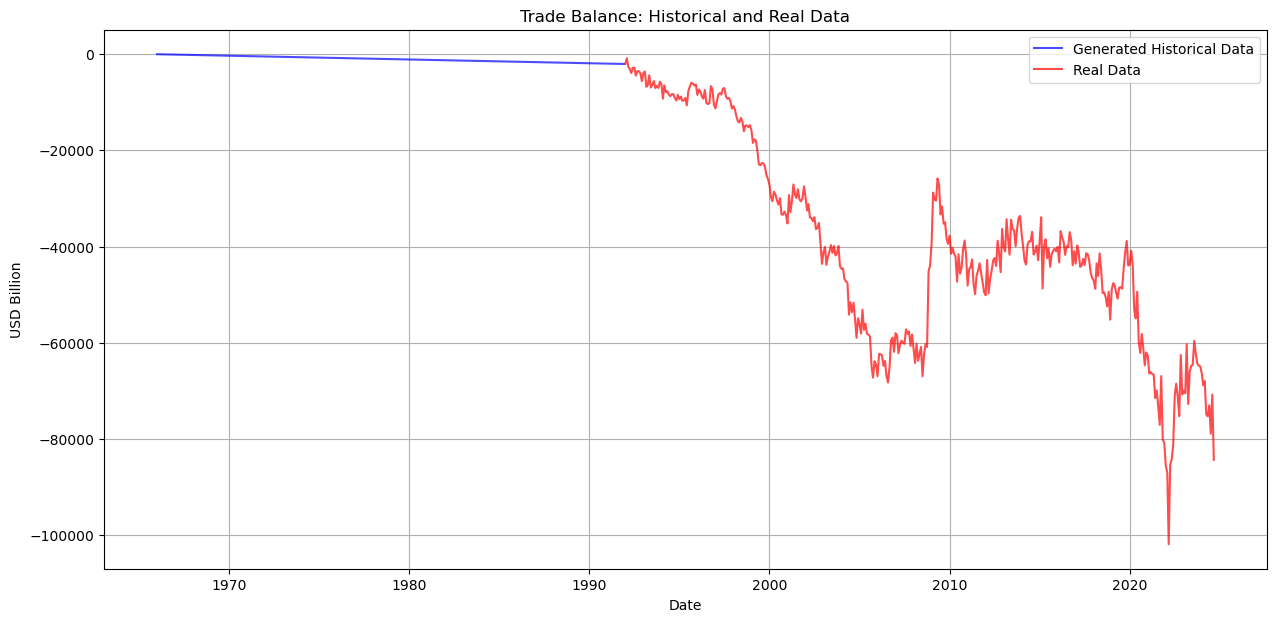


Стойност в точката на свързване (1992-01-01 00:00:00):
Последна историческа стойност: -2025.89
Първа реална стойност: -2026.00


,date,tb
0,1966-01-01,-0.700329
1,1966-02-01,-7.275884
2,1966-03-01,-13.709347
3,1966-04-01,-20.133871
4,1966-05-01,-26.821647
...,...,...
700,2024-05-01,-75306.000000
701,2024-06-01,-73016.000000
702,2024-07-01,-78918.000000
703,2024-08-01,-70787.000000


In [33]:
tb_file['date'] = pd.to_datetime(tb_file['date'])

# Генериране на исторически данни от 1966 до първата налична дата
def generate_historical_data(start_date, end_date, end_value):
    dates = pd.date_range(start=start_date, end=end_date, freq='MS')
    n_points = len(dates)
    
    # Започваме от приблизително -0.75 милиарда (базирано на графиката)
    base_value = -0.75
    
    # Генерираме стойности с постепенно влошаване
    values = np.linspace(base_value, end_value, n_points)
    
    # Добавяме малки флуктуации за реалистичност
    np.random.seed(42)
    fluctuations = np.random.normal(0, 0.1, n_points)
    values = values + fluctuations
    
    return pd.DataFrame({
        'date': dates,
        'tb': values
    })

# Определяне на параметрите за генериране
start_date = "1966-01-01"
end_date = tb_file['date'].min() - pd.DateOffset(months=1)
end_value = tb_file['tb'].iloc[0]  # Първата стойност от реалните данни

# Генериране на исторически данни
historical_tb = generate_historical_data(start_date, end_date, end_value)

# Обединяване на историческите и реалните данни
tb = pd.concat([historical_tb, tb_file]).reset_index(drop=True)

# Сортиране по дата
tb = tb.sort_values('date').reset_index(drop=True)

# Визуализация на резултатите
plt.figure(figsize=(15, 7))
plt.plot(historical_tb['date'], historical_tb['tb'], label='Generated Historical Data', 
         color='blue', alpha=0.7)
plt.plot(tb_file['date'], tb_file['tb'], label='Real Data', 
         color='red', alpha=0.7)
plt.title('Trade Balance: Historical and Real Data')
plt.xlabel('Date')
plt.ylabel('USD Billion')
plt.grid(True)
plt.legend()
plt.show()

# Проверка на връзката между историческите и реалните данни
transition_date = tb_file['date'].min()
print(f"\nСтойност в точката на свързване ({transition_date}):")
print(f"Последна историческа стойност: {tb[tb['date'] < transition_date]['tb'].iloc[-1]:.2f}")
print(f"Първа реална стойност: {tb[tb['date'] >= transition_date]['tb'].iloc[0]:.2f}")

tb

#### 2.13  Personal consumption expenditures: Energy goods and services (DNRGRC1M027SBEA)

From this site **[Federal Reserve Bank of St. Louis](https://fred.stlouisfed.org/series/DNRGRC1M027SBEA)** we only download information for the period of our study: **<a style="color:purple;">Energy goods and services (DNRGRC1M027SBEA)</a>**, Units: **Billions of Dollars**, Seasonally Adjusted. Frequency: Monthly [xx]

In [35]:
energy = pd.read_csv('data/DNRGRC1M027SBEA.csv') # Loading data.
energy.columns = ["date", "energy"]
energy

,date,energy
0,1966-01-01,31.2
1,1966-02-01,30.9
2,1966-03-01,31.2
3,1966-04-01,31.7
4,1966-05-01,32.0
...,...,...
700,2024-05-01,782.3
701,2024-06-01,760.0
702,2024-07-01,766.8
703,2024-08-01,753.6


In [36]:
# Create a new empty table.
data = pd.DataFrame(columns=[
    'gdp', # GROSS DOMESTIC PRODUCT
    'cpi', # CONSUMER PRICE INDEX
    'indpro', # Industrial Production Index
    'sp500', # S&P 500 Index
    'payems', # Total Nonfarm Payroll
    'unemployment', # UNEMPLOYMEN
    'fedfunds', # Federal Funds Effective Rate
    'debt', # Total Public Debt
    'pasavert', #  Personal Saving Rate
    'gdp_pca', # Real GDP per capita
    'debt_per_gdp', # Total Public Debt as Percent of GDP
    'tb', # Trade Balance
    'energy' # PCE: Energy goods and services
])
# Add data to the columns.
data['gdp'] = gdp_approx['gdp']
data['cpi'] = cpi['cpi']
data['indpro'] = indpro['indpro']
data['sp500'] = sp500['sp500']
data['payems'] = payems['payems']
data['unemployment'] = unemployment['unemployment']
data['fedfunds'] = fedfunds['fedfunds']
data['debt'] = debt_approx['debt']
data['pasavert'] = pasavert['pasavert']
data['gdp_pca'] = gdp_pca_approx['gdp_pca']
data['debt_per_gdp'] = debt_per_gdp['debt_per_gdp']
data['tb'] = tb['tb']
data['energy'] = energy['energy']

In [37]:
# Create list of monthly dates.
dates = pd.date_range(start='01-1966', end='09-2024', freq='MS')
formatted_dates = pd.to_datetime(dates)

# Assuming collected_data is already an existing DataFrame with some data.
# Check the length of data to ensure it matches the length of formatted_dates.
if len(data) == len(formatted_dates):
    data['date'] = formatted_dates
else:
    print("The length of collected_data does not match the length of formatted_dates!")
data.set_index('date', inplace=True)

data.to_csv(r'data/data.csv') # We save the dataframe to a file.

data

,gdp,cpi,indpro,sp500,payems,unemployment,fedfunds,debt,pasavert,gdp_pca,debt_per_gdp,tb,energy
date,,,,,,,,,,,,,
1966-01-01,7.957340e+11,31.880,33.1709,92.88,62529,0.040,0.0442,3.209990e+11,0.112,24172.000000,0.403400,-0.700329,31.2
1966-02-01,7.988163e+11,32.080,33.3859,91.22,62796,0.038,0.0460,3.193650e+11,0.110,24178.333333,0.399798,-7.275884,30.9
1966-03-01,8.018987e+11,32.180,33.8429,89.23,63192,0.038,0.0466,3.177310e+11,0.107,24184.666667,0.396223,-13.709347,31.2
1966-04-01,8.049810e+11,32.280,33.8967,91.06,63437,0.038,0.0467,3.160970e+11,0.103,24191.000000,0.392676,-20.133871,31.7
1966-05-01,8.098667e+11,32.350,34.2192,86.13,63712,0.039,0.0490,3.189807e+11,0.112,24234.333333,0.393868,-26.821647,32.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-01,2.912778e+13,313.225,103.0711,5277.51,158430,0.040,0.0533,3.483163e+13,0.052,69103.666667,1.195822,-75306.000000,782.3
2024-06-01,2.923885e+13,313.049,103.2258,5460.48,158548,0.041,0.0533,3.483163e+13,0.052,69230.333333,1.191279,-73016.000000,760.0
2024-07-01,2.934992e+13,313.534,102.5863,5522.30,158692,0.043,0.0533,3.483163e+13,0.049,69357.000000,1.186771,-78918.000000,766.8


### 3. **Analysis of economic sustainability**

Binary classification (stable/unstable economy)

**Input**: GDP, CPI, INDPRO, SP500, PAYEMS, UNRATE, FEDFUNDS, GFDEBTN, PSAVERT, A939RX0Q048SBEA, GFDEGDQ188S, BOPGSTB, DNRGRC1M027SBEA<br>
**Target**: Composite Health Score (we will create it as a weighted sum of normalized metrics).<br>
<a style="color:red;">
**Model**: 1D CNN + LSTM<br>
**Objective**: Estimating overall economic health using an LSTM network as we work with time series.<br><br>
This model offers several key functionalities:<br>
Creates a composite index of economic health based on all indicators. Uses LSTM architecture to capture long-term dependencies.
Includes dropout layers to prevent overfitting. Prepares data in appropriate sequences for temporal analysis.
Normalizes input and output data. Detailed model explanation:</a>

The model is a combination of 1D Convolutional Neural Network (CNN) and Long Short-Term Memory (LSTM) layers.

1D CNN:
The 1D CNN is used to extract features from the input sequence. 1D convolution is applied along the temporal dimension (time steps) to capture local patterns in the data.
CNNs are effective at learning spatial features, which can be useful for processing time series data like the economic indicators you mentioned.

LSTM:
The LSTM layers are used to capture the temporal dependencies in the data. LSTMs are a type of recurrent neural network (RNN) that are particularly good at learning long-term dependencies in sequence data.
LSTMs have gating mechanisms that allow them to selectively remember and forget information from previous time steps, which is useful for modeling complex time series patterns.

The model architecture you provided has the following structure:

- An LSTM layer with 128 units and return_sequences=True. This means the LSTM will output a sequence of 128-dimensional vectors, one for each time step.
- A Dropout layer with a rate of 0.2 to prevent overfitting.
- Another LSTM layer with 64 units and return_sequences=False. This layer outputs a single 64-dimensional vector summarizing the entire input sequence.
- Another Dropout layer with a rate of 0.2.
- A Dense (fully connected) layer with 32 units and a ReLU activation function. This adds a final layer of processing to the output of the LSTM.
- A final Dense layer with 1 unit, which will produce the final scalar output (the predicted economic health score).

The combination of 1D CNN and LSTM allows the model to first extract relevant features from the input sequence using the CNN, and then model the temporal dependencies in those features using the LSTM. This type of hybrid architecture can be effective for time series forecasting and sequence-to-value problems like predicting an economic health score.

**<a style="color:red;">ERROR !!! CHECK THIS @@ !!!</a>**

Here is a justification for the chosen weights in the new model:

**Positive indicators**:

 - GDP ( 0.15 ) - Heaviest weight, as it is a key indicator of economic development.
 - INDPRO ( 0.10 ) - Important indicator of the productive capacity of the economy.
 - SP500 ( 0.05 ) - Less weight, as it reflects only financial markets.
 - PAYEMS ( 0.10 ) - Significant weight due to the importance of employment.
 - GDP_PCA ( 0.10 ) - Important indicator of the well-being of the population.
 - PASAVERT ( 0.05 ) - Less weight, but important for financial stability.

**Negative indicators**:

 - CPI ( -0.10 ) - Significant negative weight due to the influence of inflation.
 - UNEMPLOYMENT ( -0.10 ) - Also significant negative influence.
 - FEDFUNDS ( -0.05 ) - Less weight, affects indirectly.
 - DEBT_PER_GDP ( -0.10 ) - Significant weight due to the importance of the debt burden.
 - TB ( -0.05 ) - Less weight, but important for foreign economic relations.
 - ENERGY ( -0.05 ) - Less weight, but important for energy dependence.

The sum of all weights is zero, which provides a balanced model.<br>
The main macroeconomic indicators (GDP, CPI, UNEMPLOYMENT, DEBT_PER_GDP) have the greatest influence, while derived or more specific indicators have smaller weights.

Training the model with 1D CNN + LSTM...
Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0579 - mae: 0.1761 - val_loss: 0.0112 - val_mae: 0.0839
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0073 - mae: 0.0648 - val_loss: 0.0061 - val_mae: 0.0562
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0036 - mae: 0.0435 - val_loss: 0.0057 - val_mae: 0.0419
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0022 - mae: 0.0357 - val_loss: 0.0085 - val_mae: 0.0630
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0023 - mae: 0.0356 - val_loss: 0.0064 - val_mae: 0.0498
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0022 - mae: 0.0332 - val_loss: 0.0081 - val_mae: 0.0665
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019 - mae: 0.0331 - val_loss: 0.0161 - val_mae: 0.1123
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0019 - mae: 0.0328 - val_loss: 0.0092 - val_mae: 0.0753
Epoch 9/50
18/18 ━━━━━━━━━━━━━

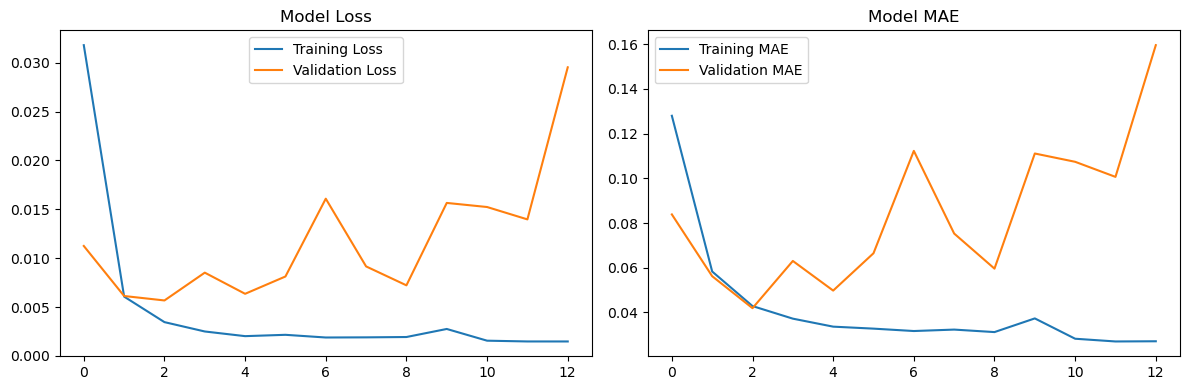

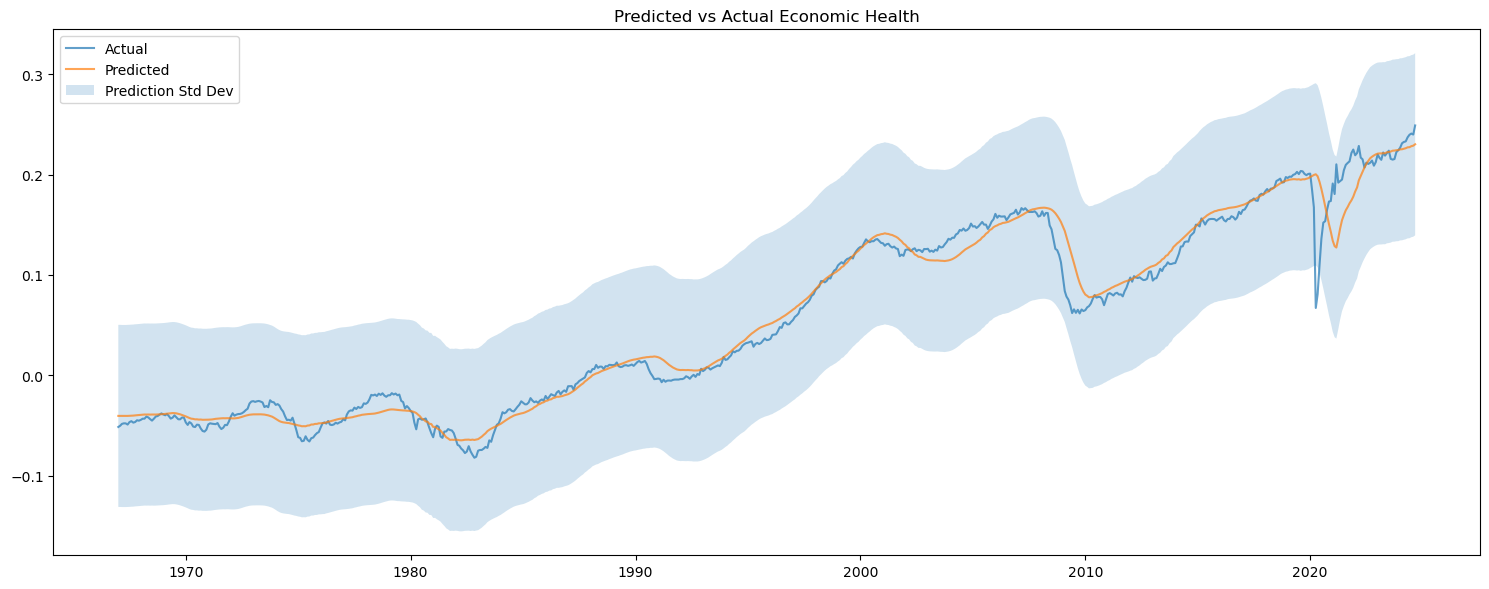

In [41]:
warnings.filterwarnings('ignore')

# Клас за предсказване на икономическо здраве
class EconomicHealthPredictor:
    def __init__(self, lookback=12):
        self.lookback = lookback
        self.scaler_X = MinMaxScaler()
        self.scaler_y = MinMaxScaler()
        self.model = None

    def create_composite_health_score(self, data):
        """
        Creates a composite index of economic health with updated indicators.
        
        Positive indicators: 
        - GDP (core economic growth indicator)
        - INDPRO (industrial production)
        - SP500 (market stability)
        - PAYEMS (employment)
        - GDP_PCA (population welfare)
        - PASAVERT (population savings)

        Negative indicators:
        - CPI (inflation)
        - UNEMPLOYMENT (unemployment)
        - FEDFUNDS (cost of borrowing)
        - DEBT_PER_GDP (debt burden)
        - TB (trade deficit)
        - ENERGY (energy costs)
        """
        weights = {
            'gdp': 0.15,          # A key indicator of economic health.
            'indpro': 0.10,       # Production capacity indicator.
            'sp500': 0.05,        # Market confidence indicator.
            'payems': 0.10,       # An important indicator of employment.
            'gdp_pca': 0.10,      # Standard of living indicator.
            'pasavert': 0.05,     # Household financial stability indicator.
            'cpi': -0.10,         # Negative impact of inflation.
            'unemployment': -0.10, # Main negative social indicator.
            'fedfunds': -0.05,    # Impact on the price of loans.
            'debt_per_gdp': -0.10,# Long-term financial stability.
            'tb': -0.05,          # Foreign trade balance.
            'energy': -0.05       # Energy dependence.
       }
        normalized_data = self.scaler_X.fit_transform(data)
        df_normalized = pd.DataFrame(normalized_data, columns=data.columns)

        health_score = sum(
            df_normalized[col] * weight for col, weight in weights.items() if col in df_normalized.columns
        )
        return health_score

    def prepare_sequences(self, X, y):
        X_seq, y_seq = [], []
        for i in range(len(X) - self.lookback):
            X_seq.append(X[i:(i + self.lookback)])
            y_seq.append(y[i + self.lookback])
        return np.array(X_seq), np.array(y_seq)

    def build_model(self, input_shape):
        """
        Creates a model with 1D CNN and LSTM.
        """
        model = Sequential([
            Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape),
            MaxPooling1D(pool_size=2),
            LSTM(128, return_sequences=True),
            Dropout(0.2),
            LSTM(64, return_sequences=False),
            Dropout(0.2),
            Dense(32, activation='relu'),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mse', metrics=['mae'])
        return model

    def fit(self, X, epochs=100, validation_split=0.2, verbose=0):
        y = self.create_composite_health_score(X)
        X_scaled = self.scaler_X.fit_transform(X)
        y_scaled = self.scaler_y.fit_transform(y.values.reshape(-1, 1))

        X_seq, y_seq = self.prepare_sequences(X_scaled, y_scaled)
        self.model = self.build_model((self.lookback, X.shape[1]))

        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        history = self.model.fit(
            X_seq, y_seq,
            epochs=epochs,
            validation_split=validation_split,
            callbacks=[early_stopping],
            verbose=verbose
        )

        return history

    def predict(self, X):
        X_scaled = self.scaler_X.transform(X)
        X_seq, _ = self.prepare_sequences(X_scaled, np.zeros(len(X_scaled)))
        predictions = self.model.predict(X_seq, verbose=0)
        return self.scaler_y.inverse_transform(predictions)

def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Model MAE')
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_predictions(true_values, predictions, dates):
    true_values = np.array(true_values).flatten()
    predictions = np.array(predictions).flatten()

    plt.figure(figsize=(15, 6))
    plt.plot(dates, true_values, label='Actual', alpha=0.7)
    plt.plot(dates, predictions, label='Predicted', alpha=0.7)

    std_dev = predictions.std()
    plt.fill_between(
        dates,
        predictions - std_dev,
        predictions + std_dev,
        alpha=0.2,
        label='Prediction Std Dev'
    )
    
    plt.title('Predicted vs Actual Economic Health')
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

# Главна функция за анализ
def run_analysis(data):
    print("Training the model with 1D CNN + LSTM...")
    predictor = EconomicHealthPredictor(lookback=12)
    history = predictor.fit(data, epochs=50, validation_split=0.2, verbose=1)

    # Визуализация на процеса на обучение
    plot_training_history(history)

    # Правене на предикции
    predictions = predictor.predict(data)
    health_score = predictor.create_composite_health_score(data)

    # Визуализация на предикциите
    plot_predictions(health_score[12:], predictions, data.index[12:])

    return predictor

# Изпълнение на анализа с примерни данни
if __name__ == "__main__":
    # Зареждане на примерни данни
    data = pd.read_csv("data/data.csv", index_col=0, parse_dates=True)
    predictor = run_analysis(data)

Training the model with 1D CNN + LSTM...
Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0916 - mae: 0.2270 - val_loss: 0.0058 - val_mae: 0.0512
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0065 - mae: 0.0582 - val_loss: 0.0084 - val_mae: 0.0743
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0035 - mae: 0.0435 - val_loss: 0.0194 - val_mae: 0.1177
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0025 - mae: 0.0361 - val_loss: 0.0181 - val_mae: 0.1107
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0020 - mae: 0.0326 - val_loss: 0.0153 - val_mae: 0.0992
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0026 - mae: 0.0363 - val_loss: 0.0247 - val_mae: 0.1397
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0017 - mae: 0.0302 - val_loss: 0.0130 - val_mae: 0.0895
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0020 - mae: 0.0307 - val_loss: 0.0210 - val_mae: 0.1263
Epoch 9/50
18/18 ━━━━━━━━━━━━━

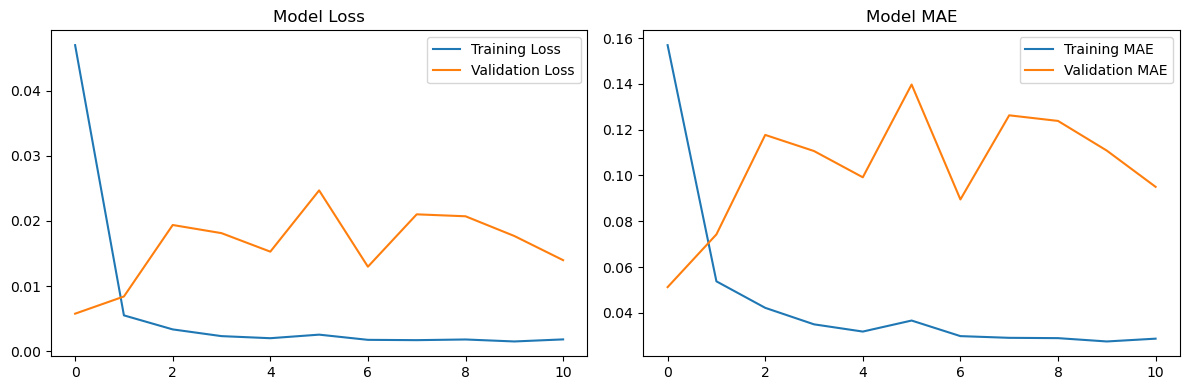

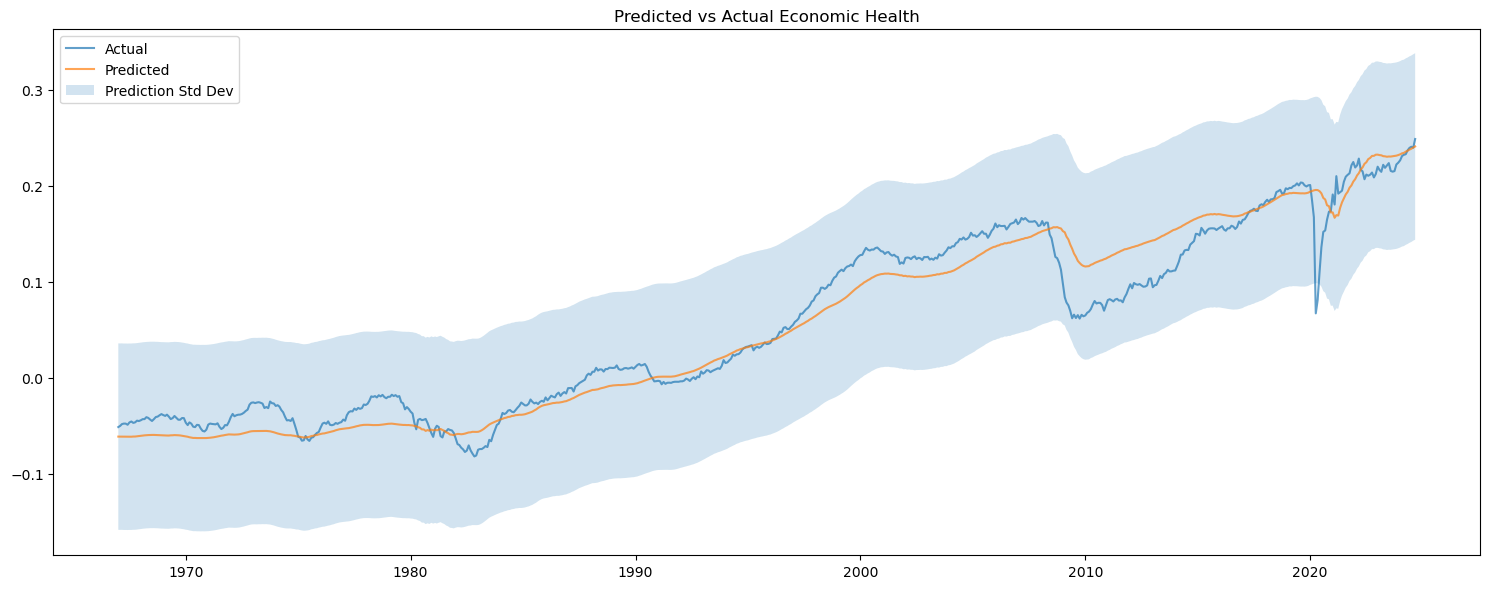

In [42]:
# Клас за предсказване на икономическо здраве
class EconomicHealthPredictor:
    def __init__(self, lookback=12):
        self.lookback = lookback
        self.scaler_X = MinMaxScaler()
        self.scaler_y = MinMaxScaler()
        self.model = None

    def create_composite_health_score(self, data):
        """
        Creates a composite index of economic health with updated indicators.
        
        Positive indicators: 
        - GDP (основен показател за икономически растеж)
        - INDPRO (индустриално производство)
        - SP500 (пазарна стабилност)
        - PAYEMS (заетост)
        - GDP_PCA (благосъстояние на населението)
        - PASAVERT (спестявания на населението)
        
        Negative indicators:
        - CPI (инфлация)
        - UNEMPLOYMENT (безработица)
        - FEDFUNDS (цена на заемите)
        - DEBT_PER_GDP (дългова тежест)
        - TB (търговски дефицит)
        - ENERGY (енергийни разходи)
        """
        weights = {
            'gdp': 0.15,          # Основен индикатор за икономическо здраве
            'indpro': 0.10,       # Показател за производствен капацитет
            'sp500': 0.05,        # Индикатор за пазарно доверие
            'payems': 0.10,       # Важен индикатор за заетостта
            'gdp_pca': 0.10,      # Показател за жизнен стандарт
            'pasavert': 0.05,     # Индикатор за финансова стабилност на домакинствата
            'cpi': -0.10,         # Негативно влияние на инфлацията
            'unemployment': -0.10, # Основен негативен социален показател
            'fedfunds': -0.05,    # Влияние върху цената на кредитите
            'debt_per_gdp': -0.10,# Дългосрочна финансова стабилност
            'tb': -0.05,          # Външнотърговски баланс
            'energy': -0.05       # Енергийна зависимост
       }
        normalized_data = self.scaler_X.fit_transform(data)
        df_normalized = pd.DataFrame(normalized_data, columns=data.columns)

        health_score = sum(
            df_normalized[col] * weight for col, weight in weights.items() if col in df_normalized.columns
        )
        return health_score

    def prepare_sequences(self, X, y):
        X_seq, y_seq = [], []
        for i in range(len(X) - self.lookback):
            X_seq.append(X[i:(i + self.lookback)])
            y_seq.append(y[i + self.lookback])
        return np.array(X_seq), np.array(y_seq)

    def build_model(self, input_shape):
        """
        Creates a model with 1D CNN and LSTM.
        """
        model = Sequential([
            Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape),
            MaxPooling1D(pool_size=2),
            LSTM(128, return_sequences=True),
            Dropout(0.2),
            LSTM(64, return_sequences=False),
            Dropout(0.2),
            Dense(32, activation='relu'),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mse', metrics=['mae'])
        return model

    def fit(self, X, epochs=100, validation_split=0.2, verbose=0):
        y = self.create_composite_health_score(X)
        X_scaled = self.scaler_X.fit_transform(X)
        y_scaled = self.scaler_y.fit_transform(y.values.reshape(-1, 1))

        X_seq, y_seq = self.prepare_sequences(X_scaled, y_scaled)
        self.model = self.build_model((self.lookback, X.shape[1]))

        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        history = self.model.fit(
            X_seq, y_seq,
            epochs=epochs,
            validation_split=validation_split,
            callbacks=[early_stopping],
            verbose=verbose
        )

        return history

    def predict(self, X):
        X_scaled = self.scaler_X.transform(X)
        X_seq, _ = self.prepare_sequences(X_scaled, np.zeros(len(X_scaled)))
        predictions = self.model.predict(X_seq, verbose=0)
        return self.scaler_y.inverse_transform(predictions)

def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Model MAE')
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_predictions(true_values, predictions, dates):
    true_values = np.array(true_values).flatten()
    predictions = np.array(predictions).flatten()

    plt.figure(figsize=(15, 6))
    plt.plot(dates, true_values, label='Actual', alpha=0.7)
    plt.plot(dates, predictions, label='Predicted', alpha=0.7)

    std_dev = predictions.std()
    plt.fill_between(
        dates,
        predictions - std_dev,
        predictions + std_dev,
        alpha=0.2,
        label='Prediction Std Dev'
    )
    
    plt.title('Predicted vs Actual Economic Health')
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

# Главна функция за анализ
def run_analysis(data):
    print("Training the model with 1D CNN + LSTM...")
    predictor = EconomicHealthPredictor(lookback=12)
    history = predictor.fit(data, epochs=50, validation_split=0.2, verbose=1)

    # Визуализация на процеса на обучение
    plot_training_history(history)

    # Правене на предикции
    predictions = predictor.predict(data)
    health_score = predictor.create_composite_health_score(data)

    # Визуализация на предикциите
    plot_predictions(health_score[12:], predictions, data.index[12:])

    return predictor

# Изпълнение на анализа с примерни данни
if __name__ == "__main__":
    # Зареждане на примерни данни
    data = pd.read_csv("data/data.csv", index_col=0, parse_dates=True)
    predictor = run_analysis(data)

Training the model without 1D CNN...
Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0449 - mae: 0.1570 - val_loss: 0.0051 - val_mae: 0.0526
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0069 - mae: 0.0617 - val_loss: 0.0044 - val_mae: 0.0341
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0034 - mae: 0.0434 - val_loss: 0.0060 - val_mae: 0.0408
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0025 - mae: 0.0374 - val_loss: 0.0072 - val_mae: 0.0574
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0020 - mae: 0.0337 - val_loss: 0.0061 - val_mae: 0.0459
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0022 - mae: 0.0345 - val_loss: 0.0054 - val_mae: 0.0464
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0033 - mae: 0.0416 - val_loss: 0.0193 - val_mae: 0.1251
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0021 - mae: 0.0329 - val_loss: 0.0075 - val_mae: 0.0612
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━

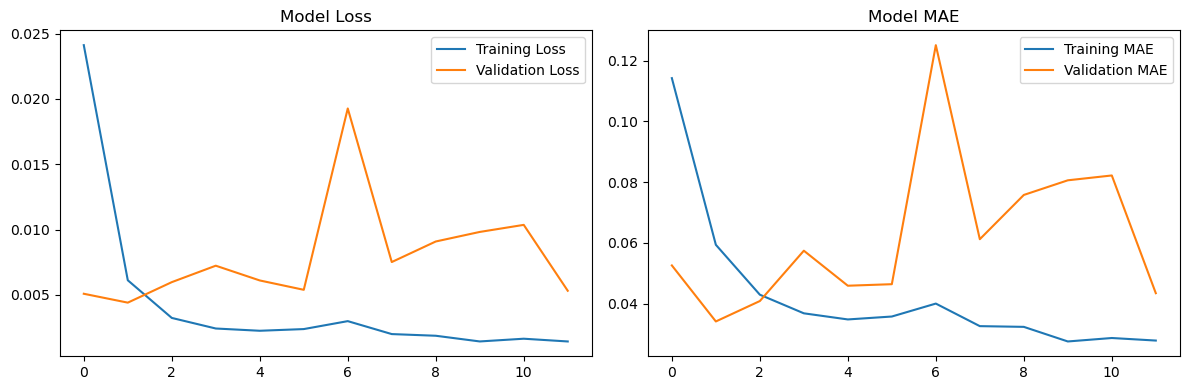

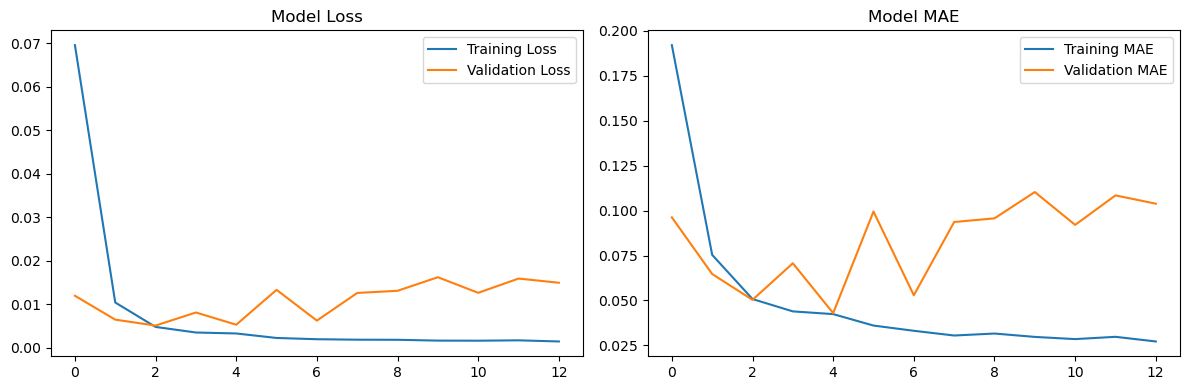

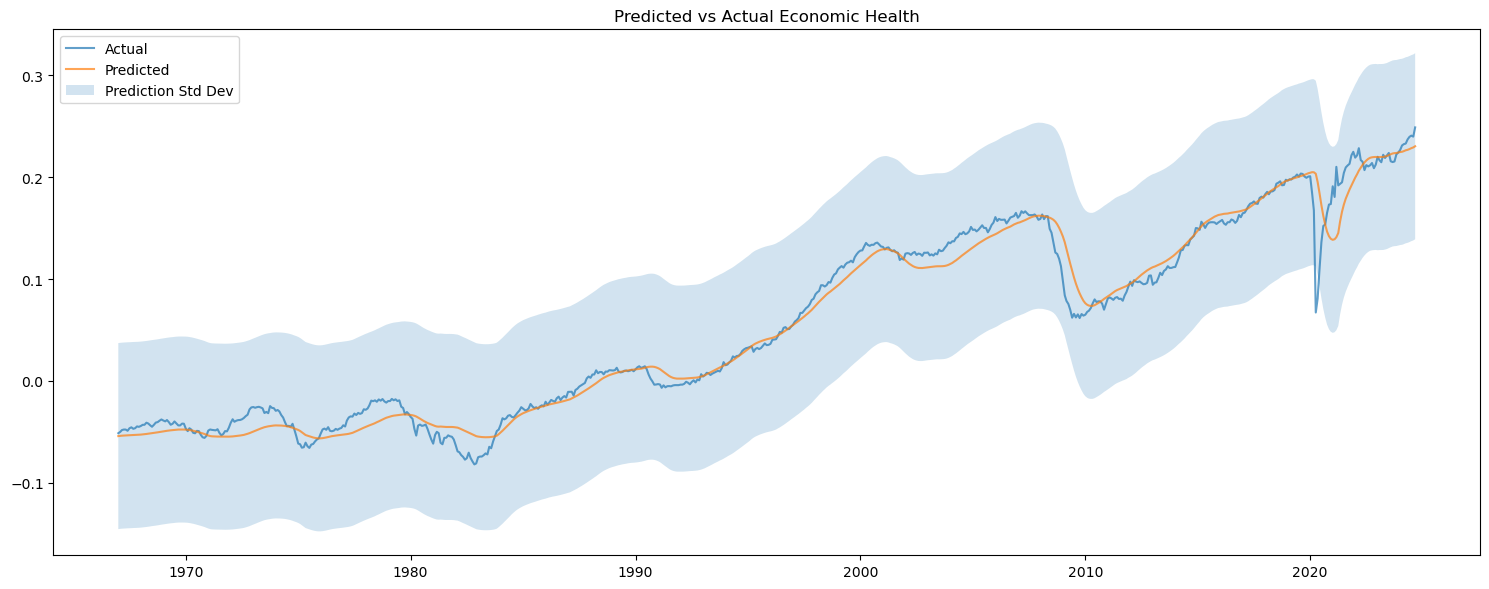

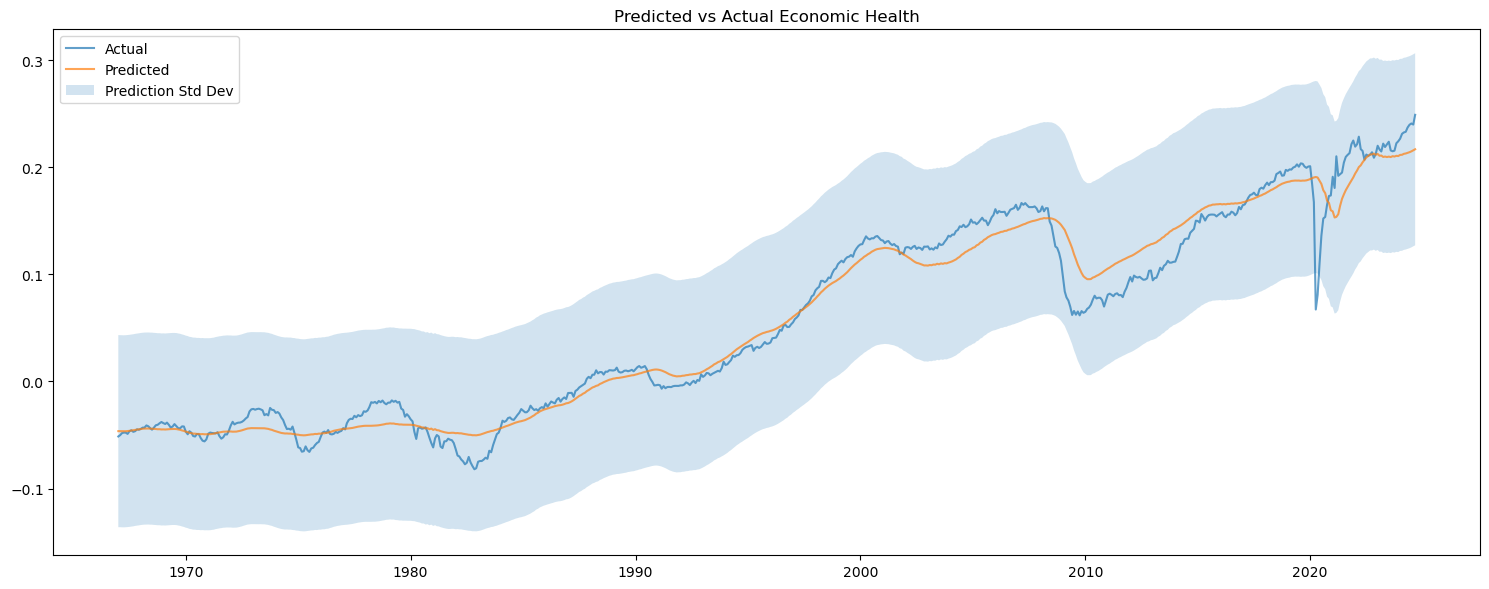

In [43]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Клас за предсказване на икономическо здраве
class EconomicHealthPredictor:
    def __init__(self, lookback=12, use_cnn=False, lstm_units=128, dropout_rate=0.2, optimizer='adam', batch_size=32):
        self.lookback = lookback
        self.use_cnn = use_cnn
        self.lstm_units = lstm_units
        self.dropout_rate = dropout_rate
        self.optimizer = optimizer
        self.batch_size = batch_size
        self.scaler_X = MinMaxScaler()
        self.scaler_y = MinMaxScaler()
        self.model = None

    def create_composite_health_score(self, data):
        """
        Creates a composite index of economic health with updated indicators.
        """
        weights = {
            'gdp': 0.15,          # Основен индикатор за икономическо здраве
            'indpro': 0.10,       # Показател за производствен капацитет
            'sp500': 0.05,        # Индикатор за пазарно доверие
            'payems': 0.10,       # Важен индикатор за заетостта
            'gdp_pca': 0.10,      # Показател за жизнен стандарт
            'pasavert': 0.05,     # Индикатор за финансова стабилност на домакинствата
            'cpi': -0.10,         # Негативно влияние на инфлацията
            'unemployment': -0.10, # Основен негативен социален показател
            'fedfunds': -0.05,    # Влияние върху цената на кредитите
            'debt_per_gdp': -0.10,# Дългосрочна финансова стабилност
            'tb': -0.05,          # Външнотърговски баланс
            'energy': -0.05       # Енергийна зависимост
       }
        normalized_data = self.scaler_X.fit_transform(data)
        df_normalized = pd.DataFrame(normalized_data, columns=data.columns)

        health_score = sum(
            df_normalized[col] * weight for col, weight in weights.items() if col in df_normalized.columns
        )
        return health_score

    def prepare_sequences(self, X, y):
        X_seq, y_seq = [], []
        for i in range(len(X) - self.lookback):
            X_seq.append(X[i:(i + self.lookback)])
            y_seq.append(y[i + self.lookback])
        return np.array(X_seq), np.array(y_seq)

    def build_model(self, input_shape):
        """
        Creates a model with or without 1D CNN based on the use_cnn flag.
        """
        model = Sequential()
        
        if self.use_cnn:
            model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape))
            model.add(MaxPooling1D(pool_size=2))
        
        model.add(LSTM(self.lstm_units, return_sequences=True))
        model.add(Dropout(self.dropout_rate))
        model.add(LSTM(self.lstm_units // 2, return_sequences=False))
        model.add(Dropout(self.dropout_rate))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(1))
        
        model.compile(optimizer=self.optimizer, loss='mse', metrics=['mae'])
        return model

    def fit(self, X, epochs=100, validation_split=0.2, verbose=0):
        y = self.create_composite_health_score(X)
        X_scaled = self.scaler_X.fit_transform(X)
        y_scaled = self.scaler_y.fit_transform(y.values.reshape(-1, 1))

        X_seq, y_seq = self.prepare_sequences(X_scaled, y_scaled)
        self.model = self.build_model((self.lookback, X.shape[1]))

        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        history = self.model.fit(
            X_seq, y_seq,
            epochs=epochs,
            validation_split=validation_split,
            callbacks=[early_stopping],
            verbose=verbose,
            batch_size=self.batch_size
        )

        return history

    def predict(self, X):
        X_scaled = self.scaler_X.transform(X)
        X_seq, _ = self.prepare_sequences(X_scaled, np.zeros(len(X_scaled)))
        predictions = self.model.predict(X_seq, verbose=0)
        return self.scaler_y.inverse_transform(predictions)

def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Model MAE')
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_predictions(true_values, predictions, dates):
    true_values = np.array(true_values).flatten()
    predictions = np.array(predictions).flatten()

    plt.figure(figsize=(15, 6))
    plt.plot(dates, true_values, label='Actual', alpha=0.7)
    plt.plot(dates, predictions, label='Predicted', alpha=0.7)

    std_dev = predictions.std()
    plt.fill_between(
        dates,
        predictions - std_dev,
        predictions + std_dev,
        alpha=0.2,
        label='Prediction Std Dev'
    )
    
    plt.title('Predicted vs Actual Economic Health')
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

# Главна функция за анализ
def run_analysis(data):
    print("Training the model without 1D CNN...")
    predictor_without_cnn = EconomicHealthPredictor(lookback=12, use_cnn=False, lstm_units=128, dropout_rate=0.2, optimizer='adam', batch_size=32)
    history_without_cnn = predictor_without_cnn.fit(data, epochs=50, validation_split=0.2, verbose=1)

    print("Training the model with 1D CNN...")
    predictor_with_cnn = EconomicHealthPredictor(lookback=12, use_cnn=True, lstm_units=128, dropout_rate=0.2, optimizer='adam', batch_size=32)
    history_with_cnn = predictor_with_cnn.fit(data, epochs=50, validation_split=0.2, verbose=1)

    # Визуализация на процеса на обучение
    plot_training_history(history_without_cnn)
    plot_training_history(history_with_cnn)

    # Правене на предикции
    predictions_without_cnn = predictor_without_cnn.predict(data)
    predictions_with_cnn = predictor_with_cnn.predict(data)
    health_score = predictor_without_cnn.create_composite_health_score(data)

    # Визуализация на предикциите
    plot_predictions(health_score[12:], predictions_without_cnn, data.index[12:])
    plot_predictions(health_score[12:], predictions_with_cnn, data.index[12:])

    return predictor_without_cnn, predictor_with_cnn

# Изпълнение на анализа с примерни данни
if __name__ == "__main__":
    # Зареждане на примерни данни
    data = pd.read_csv("data/data.csv", index_col=0, parse_dates=True)
    predictor_without_cnn, predictor_with_cnn = run_analysis(data)

**BINGO !!**

In [50]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from kerastuner.tuners import RandomSearch
from kerastuner import HyperModel

# Клас за предсказване на икономическо здраве
class EconomicHealthPredictor(HyperModel):
    def __init__(self, lookback=12):
        self.lookback = lookback
        self.scaler_X = MinMaxScaler()
        self.scaler_y = MinMaxScaler()

    def create_composite_health_score(self, data):
        """
        Creates a composite index of economic health with updated indicators.
        """
        weights = {
            'gdp': 0.15,          # Основен индикатор за икономическо здраве
            'indpro': 0.10,       # Показател за производствен капацитет
            'sp500': 0.05,        # Индикатор за пазарно доверие
            'payems': 0.10,       # Важен индикатор за заетостта
            'gdp_pca': 0.10,      # Показател за жизнен стандарт
            'pasavert': 0.05,     # Индикатор за финансова стабилност на домакинствата
            'cpi': -0.10,         # Негативно влияние на инфлацията
            'unemployment': -0.10, # Основен негативен социален показател
            'fedfunds': -0.05,    # Влияние върху цената на кредитите
            'debt_per_gdp': -0.10,# Дългосрочна финансова стабилност
            'tb': -0.05,          # Външнотърговски баланс
            'energy': -0.05       # Енергийна зависимост
       }
        normalized_data = self.scaler_X.fit_transform(data)
        df_normalized = pd.DataFrame(normalized_data, columns=data.columns)

        health_score = sum(
            df_normalized[col] * weight for col, weight in weights.items() if col in df_normalized.columns
        )
        return health_score

    def prepare_sequences(self, X, y):
        X_seq, y_seq = [], []
        for i in range(len(X) - self.lookback):
            X_seq.append(X[i:(i + self.lookback)])
            y_seq.append(y[i + self.lookback])
        return np.array(X_seq), np.array(y_seq)

    def build(self, hp):
        model = Sequential()
        
        # Hyperparameters for Conv1D
        use_cnn = hp.Boolean('use_cnn')
        if use_cnn:
            model.add(Conv1D(
                filters=hp.Int('conv1d_filters', min_value=32, max_value=128, step=32),
                kernel_size=hp.Int('conv1d_kernel_size', min_value=2, max_value=5, step=1),
                activation='relu',
                input_shape=(self.lookback, X.shape[1])
            ))
            model.add(MaxPooling1D(pool_size=2))
        
        # Hyperparameters for LSTM
        model.add(LSTM(
            units=hp.Int('lstm_units', min_value=64, max_value=256, step=64),
            return_sequences=True
        ))
        model.add(Dropout(hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)))
        model.add(LSTM(
            units=hp.Int('lstm_units', min_value=32, max_value=128, step=32),
            return_sequences=False
        ))
        model.add(Dropout(hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(1))
        
        model.compile(
            optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd']),
            loss='mse',
            metrics=['mae']
        )
        return model

    def fit(self, model, X, validation_split=0.2, verbose=0):
        y = self.create_composite_health_score(X)
        X_scaled = self.scaler_X.fit_transform(X)
        y_scaled = self.scaler_y.fit_transform(y.values.reshape(-1, 1))

        X_seq, y_seq = self.prepare_sequences(X_scaled, y_scaled)
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        history = model.fit(
            X_seq, y_seq,
            validation_split=validation_split,
            callbacks=[early_stopping],
            verbose=verbose
        )

        return history

    def predict(self, model, X):
        X_scaled = self.scaler_X.transform(X)
        X_seq, _ = self.prepare_sequences(X_scaled, np.zeros(len(X_scaled)))
        predictions = model.predict(X_seq, verbose=0)
        return self.scaler_y.inverse_transform(predictions)

def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Model MAE')
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_predictions(true_values, predictions, dates):
    true_values = np.array(true_values).flatten()
    predictions = np.array(predictions).flatten()

    plt.figure(figsize=(15, 6))
    plt.plot(dates, true_values, label='Actual', alpha=0.7)
    plt.plot(dates, predictions, label='Predicted', alpha=0.7)

    std_dev = predictions.std()
    plt.fill_between(
        dates,
        predictions - std_dev,
        predictions + std_dev,
        alpha=0.2,
        label='Prediction Std Dev'
    )
    
    plt.title('Predicted vs Actual Economic Health')
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

# Главна функция за анализ
def run_analysis(data):
    print("Training the model with Keras Tuner...")
    predictor = EconomicHealthPredictor(lookback=12)
    tuner = RandomSearch(
        predictor,
        objective='val_loss',
        max_trials=50,
        executions_per_trial=3,
        directory='economic_health_tuner',
        project_name='economic_health_prediction'
    )

    y = predictor.create_composite_health_score(data)
    X_scaled = predictor.scaler_X.fit_transform(data)
    y_scaled = predictor.scaler_y.fit_transform(y.values.reshape(-1, 1))

    X_seq, y_seq = predictor.prepare_sequences(X_scaled, y_scaled)

    tuner.search(
        X_seq, y_seq,
        epochs=50,
        validation_split=0.2,
        callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
    )

    best_model = tuner.get_best_models(num_models=1)[0]
    best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

    print("Best Hyperparameters:")
    print(best_hyperparameters.values)

    # Визуализация на процеса на обучение
    history = best_model.fit(
        X_seq, y_seq,
        epochs=50,
        validation_split=0.2,
        callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
        verbose=1
    )
    plot_training_history(history)

    # Правене на предикции
    predictions = best_model.predict(X_seq, verbose=0)
    predictions = predictor.scaler_y.inverse_transform(predictions)
    health_score = predictor.create_composite_health_score(data)

    # Визуализация на предикциите
    plot_predictions(health_score[12:], predictions, data.index[12:])

    return best_model, best_hyperparameters

# Изпълнение на анализа с примерни данни
if __name__ == "__main__":
    # Зареждане на примерни данни
    data = pd.read_csv("data/data.csv", index_col=0, parse_dates=True)
    best_model, best_hyperparameters = run_analysis(data)

Training the model with Keras Tuner...
Reloading Tuner from economic_health_tuner\economic_health_prediction\tuner0.json

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
False             |True              |use_cnn
256               |128               |lstm_units
0.2               |0.4               |dropout_rate
sgd               |sgd               |optimizer
96                |64                |conv1d_filters
4                 |2                 |conv1d_kernel_size



Traceback (most recent call last):
  File "C:\Users\USER\anaconda3\Lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\USER\anaconda3\Lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\USER\anaconda3\Lib\site-packages\keras_tuner\src\engine\tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\USER\anaconda3\Lib\site-packages\keras_tuner\src\engine\tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: EconomicHealthPredicto

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "C:\Users\USER\anaconda3\Lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\USER\anaconda3\Lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\USER\anaconda3\Lib\site-packages\keras_tuner\src\engine\tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\USER\anaconda3\Lib\site-packages\keras_tuner\src\engine\tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: EconomicHealthPredictor.fit() got an unexpected keyword argument 'epochs'


### 4. **Debt forecasting**

**Input**: GDP, FEDFUNDS, UNRATE, PCEPI, GFDEBTN, XAU<br>
**Target**: Total Public Debt as Percent of Gross Domestic Product (GFDEGDQ188S) - after 12 months<br>
**Model**: Transformer architecture<br>
**Objective**: To predict when debt will reach 175% of GDP

### 5. **Conclusions**

### Resources:
1. **Sustainable Economic Indicators**: https://www.sustainable-environment.org.uk/Indicators/Economy.php
2. **...**: ....
3. **...**: ....
4. **...**: ....
5. **...**: ....
6. **...**: ....
7. **...**: ....
8. **...**: ....
9. **...**: ....
10. **...**: ....
11. **...**: ....
12. **...**: ....
13. **...**: ....
14. **...**: ....
15. **...**: ....